In [1]:
import numpy as np
import pandas as pd
import pickle
from util import *
from sklearn.cluster import KMeans

with open('new.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)

dataset = pd.read_csv('final_1102022.csv')
#pd.read_csv('LUMEN_DS.csv', sep='|', quotechar='"', encoding='UTF-16LE')


In [2]:
display(dataset)
display(cluster_labels)

,Unnamed: 0,Order Date_0,Order Date_1,Order Date_2,Order Date_3,Order Date_4,Order Date_5,Order Date_6,Manufacturing Region,Manufacturing Location Code,...,Make vs Buy,Invoice Date,Invoice Line #,Order Line #,Invoiced qty (shipped),Ordered qty,Invoiced price,Cost of part,GM%,# of unique products on a quote
0,0,2019-08-05,1.000000,0.000000,0.688967,0.724793,-0.838280,-0.545240,North America,N7,...,BUY,2019-08-06,18645771,15791584.0,499.0,499.0,0.3900,0.4173,-0.070000,1.0
1,1,2019-11-24,0.623490,-0.781831,0.104528,-0.994522,0.793572,-0.608477,North America,N7,...,BUY,2019-11-26,18670413,15806968.0,1000.0,1000.0,0.1400,0.0257,0.816429,3.0
2,3,2020-03-10,0.623490,0.781831,-0.250653,0.968077,0.376728,0.926324,Asia,N13,...,BUY,2020-03-20,18688647,15818226.0,2000.0,5000.0,0.2000,0.0000,1.000000,1.0
3,4,2020-03-10,0.623490,0.781831,-0.250653,0.968077,0.376728,0.926324,Asia,N13,...,BUY,2020-03-20,18688639,15818226.0,1230.0,5000.0,0.2000,0.0000,1.000000,1.0
4,5,2020-03-10,0.623490,0.781831,-0.250653,0.968077,0.376728,0.926324,Asia,N13,...,BUY,2020-03-17,18687466,15818226.0,1770.0,5000.0,0.2000,0.0000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102017,1294956,2020-05-08,-0.900969,-0.433884,0.151428,0.988468,-0.586396,0.810025,North America,N7,...,BUY,2020-05-11,14731882,18486911.0,32.0,32.0,36.3200,22.5000,0.380507,5.0
1102018,1294958,2019-03-15,-0.900969,-0.433884,-0.954139,0.299363,0.309017,0.951057,North America,N15,...,MANUFACTURED,2019-03-19,9880134,14796498.0,15.0,15.0,7.0000,0.7500,0.892857,1.0
1102019,1294959,2019-06-04,0.623490,0.781831,0.809017,0.587785,-0.882048,0.471160,North America,N7,...,BUY,2019-08-12,18647035,15783555.0,10000.0,10000.0,0.0702,0.0450,0.358974,1.0
1102020,1294960,2019-06-05,-0.222521,0.974928,0.669131,0.743145,-0.890028,0.455907,North America,N7,...,BUY,2019-08-13,18646308,15783745.0,3000.0,3000.0,1.9770,1.1336,0.426606,1.0


array([37, 40, 53, ..., 37, 64, 72], dtype=int32)

In [3]:
# if we get a tuple of record_id, cluster, unpack it and merge (e.g. yet-another.pkl)
if type(cluster_labels) is tuple:
    if 'Unnamed: 0' not in dataset:
        dataset['Unnamed: 0'] = dataset.index
    
    dataset = dataset.rename(columns={'Unnamed: 0': 'record_id'})
    cluster_labels = pd.DataFrame(zip(cluster_labels[0], cluster_labels[1]), columns=['record_id', 'cluster_id'])
    dataset = dataset.merge(cluster_labels, on='record_id')
    
else: # we just got a list of clusters, hope it maches up
    dataset['cluster_id'] = cluster_labels

dataset = dataset.loc[dataset['GM%'] >= -4]
dataset = dataset.loc[dataset['GM%'] <= 1]

In [4]:
## DROP WHERE # OF DATAPOINTS < 5 (cannot cluster at all)
cluster_sizes = dataset.groupby(['cluster_id']).cluster_id.size()
bad_clusters = cluster_sizes.where(lambda x: x < 5).dropna()
print("dropping clusters: ", bad_clusters.index)

dataset = dataset.loc[~dataset['cluster_id'].isin(bad_clusters.index)]

clusters = dataset.cluster_id.unique()
print("has clusters: ", clusters, " len = ", len(clusters))

dropping clusters:  Int64Index([3, 48, 51], dtype='int64', name='cluster_id')
has clusters:  [37 40 53 63 78 57 23 67 77 69 35 66 20 26 70 62 52 72 21 82 13 87 27 80
 25 61 81 32 46 68 74 17 29 38 28 33 16 45 42 10 19 76  2 39 65 22 41 79
 86 34 84 49 71 59  0 58 43 24 83 18  1 15 73 54 50 44 64  6 30 31 56 47
  7 55 75 12 11 36  9 60  8  5 14]  len =  83


In [5]:
#kmeans = [KMeans(n_clusters=5).fit(np.array(dataset.loc[dataset.cluster_id == cid]['GM%'].array).reshape(-1, 1)) for cid in cluster_labels]

kmeans_objs = [] # list of tuples - cluster id, corresponding KMeans obj
for cid in clusters:
    data = np.array(dataset.loc[dataset.cluster_id == cid]['GM%'].array).reshape(-1, 1)
    #print("training KMeans on {} datapoints for cluster {}".format(data.shape[0], cid))
    kmeans = KMeans(n_clusters=5).fit(data)
    kmeans_objs.append((cid, kmeans))

In [6]:
# dataset diff between max and min GM%
print("in entire dataset, gm% range: ", dataset['GM%'].max() - dataset['GM%'].min())

dgb = dataset.groupby(['cluster_id'])
gm_ranges = (dgb['GM%'].max() - dgb['GM%'].min())
print(gm_ranges)



in entire dataset, gm% range:  5.0
cluster_id
0     4.888889
1     4.975000
2     4.989899
5     2.352332
6     5.000000
        ...   
82    4.998483
83    4.868841
84    4.884615
86    4.990884
87    4.963552
Name: GM%, Length: 83, dtype: float64


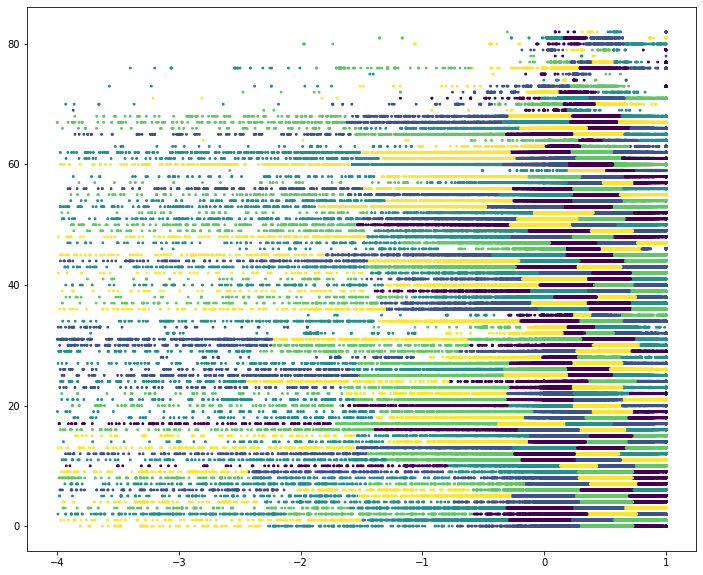

In [7]:
# assign price grades for each cluster centroid/labels
import matplotlib.pyplot as plt
for cid, kmeans in kmeans_objs:
    dataset.loc[dataset.cluster_id == cid, 'price_grade_cluster_ind'] = kmeans.labels_

dataset['price_grade_cluster_ind'] = dataset['price_grade_cluster_ind'].astype(int)


fig = plt.gcf()
fig.set_size_inches(12, 10)

i = 0
for cid in clusters:
    data = dataset.loc[dataset.cluster_id == cid]
    
    plt.scatter(data['GM%'], [i]*data.shape[0], marker='x', s=4,c=data['price_grade_cluster_ind'])
    i+=1
#fig.savefig('test2png.png', dpi=200)


In [8]:
clusters_df = pd.DataFrame(clusters, columns=['cluster_id'])
clusters_df.set_index('cluster_id')

for cid, kmeans in kmeans_objs:
    label_center = sorted(zip(range(5), kmeans.cluster_centers_), key=lambda el: el[1], reverse=True)
    clusters_df.loc[clusters_df.cluster_id == cid, 'a_label'] = label_center[0][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'b_label'] = label_center[1][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'c_label'] = label_center[2][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'd_label'] = label_center[3][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'f_label'] = label_center[4][0]
    
    clusters_df.loc[clusters_df.cluster_id == cid, 'a_center'] = label_center[0][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'b_center'] = label_center[1][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'c_center'] = label_center[2][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'd_center'] = label_center[3][1]
    clusters_df.loc[clusters_df.cluster_id == cid, 'f_center'] = label_center[4][1]
    
clusters_df = clusters_df.astype({'a_label': int, 'b_label': int, 'c_label': int, 'd_label': int, 'f_label': int})

In [9]:
#assign 'price_grade' column to dataset

for cid in clusters:
    a_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['a_label'])
    b_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['b_label'])
    c_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['c_label'])
    d_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['d_label'])
    f_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['f_label'])

    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == a_label_for_cluster), 'price_grade'] = 'A'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == b_label_for_cluster), 'price_grade'] = 'B'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == c_label_for_cluster), 'price_grade'] = 'C'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == d_label_for_cluster), 'price_grade'] = 'D'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == f_label_for_cluster), 'price_grade'] = 'F'

In [10]:
price_grade_sizes = dataset[['cluster_id', 'price_grade']].groupby(['cluster_id', 'price_grade'], as_index=False).size()
a_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='A'][['cluster_id', 'size']].rename(columns={'size':'a_size'})
b_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='B'][['cluster_id', 'size']].rename(columns={'size':'b_size'})
c_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='C'][['cluster_id', 'size']].rename(columns={'size':'c_size'})
d_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='D'][['cluster_id', 'size']].rename(columns={'size':'d_size'})
f_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='F'][['cluster_id', 'size']].rename(columns={'size':'f_size'})

clusters_df = clusters_df.merge(a_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(b_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(c_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(d_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(f_price_grade_sizes, on=['cluster_id'])

In [11]:

cluster_sizes = dataset.groupby(['cluster_id'], as_index=False).cluster_id.size().rename(columns={'size': 'cluster_size'})
clusters_df = clusters_df.merge(cluster_sizes, on=['cluster_id'])


In [12]:
clusters_df['Adata%'] = 100.0*(clusters_df['a_size']/clusters_df['cluster_size']).round(4)
clusters_df['Bdata%'] = 100.0*(clusters_df['b_size']/clusters_df['cluster_size']).round(4)
clusters_df['Cdata%'] = 100.0*(clusters_df['c_size']/clusters_df['cluster_size']).round(4)
clusters_df['Ddata%'] = 100.0*(clusters_df['d_size']/clusters_df['cluster_size']).round(4)
clusters_df['Fdata%'] = 100.0*(clusters_df['f_size']/clusters_df['cluster_size']).round(4)
clusters_df = clusters_df.sort_values(by='cluster_id')


In [13]:
clusters_df

,cluster_id,a_label,b_label,c_label,d_label,f_label,a_center,b_center,c_center,d_center,...,b_size,c_size,d_size,f_size,cluster_size,Adata%,Bdata%,Cdata%,Ddata%,Fdata%
54,0,3,1,0,4,2,0.895531,0.387508,0.067634,-0.581250,...,4228,7778,613,157,14081,9.27,30.03,55.24,4.35,1.11
60,1,3,0,1,2,4,0.756356,0.377102,0.029163,-0.721138,...,11350,4602,797,179,20915,19.06,54.27,22.00,3.81,0.86
42,2,3,0,1,2,4,0.921340,0.514200,0.255854,-0.350216,...,5662,5960,720,53,15132,18.09,37.42,39.39,4.76,0.35
81,5,4,1,0,2,3,0.910027,0.495639,0.219937,0.087916,...,690,1175,1661,6,3578,1.29,19.28,32.84,46.42,0.17
67,6,4,0,2,1,3,0.828616,0.378023,0.048198,-0.753637,...,5998,7605,612,143,15645,8.23,38.34,48.61,3.91,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,82,0,4,1,3,2,0.925976,0.527407,0.253825,-0.450371,...,4680,4584,447,67,12089,19.12,38.71,37.92,3.70,0.55
58,83,0,1,3,4,2,0.867696,0.451956,0.155201,-0.445332,...,7481,3773,641,68,14544,17.75,51.44,25.94,4.41,0.47
50,84,2,1,4,0,3,0.776922,0.392020,0.066612,-0.637911,...,10784,5064,941,171,20954,19.06,51.47,24.17,4.49,0.82
48,86,0,3,1,2,4,0.745988,0.388857,0.069951,-0.622712,...,9865,4554,828,155,18999,18.93,51.92,23.97,4.36,0.82


In [15]:
gm_ranges = dataset.groupby(['cluster_id', 'price_grade'], as_index=False).agg({'GM%': ['min', 'max']})
gm_ranges.columns = ['cluster_id', 'price_grade', 'gm%min', 'gm%max']
clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'A'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Agm%min', 'gm%max': 'Agm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'B'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Bgm%min', 'gm%max': 'Bgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'C'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Cgm%min', 'gm%max': 'Cgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'D'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Dgm%min', 'gm%max': 'Dgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'F'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Fgm%min', 'gm%max': 'Fgm%max'})

In [16]:
clusters_df['total_pricing_width'] = clusters_df['Agm%max'] - clusters_df['Fgm%min']
clusters_df['Apricing_width%'] = (100.0*(clusters_df['Agm%max'] - (clusters_df['a_center'] + clusters_df['b_center'])/2)/clusters_df['total_pricing_width']).round(2)
clusters_df['Bpricing_width%'] = (100.0*((clusters_df['a_center'] + clusters_df['b_center'])/2 - (clusters_df['c_center'] + clusters_df['b_center'])/2)/clusters_df['total_pricing_width']).round(2)
clusters_df['Cpricing_width%'] = (100.0*((clusters_df['b_center'] + clusters_df['c_center'])/2 - (clusters_df['c_center'] + clusters_df['d_center'])/2)/clusters_df['total_pricing_width']).round(2)
clusters_df['Dpricing_width%'] = (100.0*((clusters_df['c_center'] + clusters_df['d_center'])/2 - (clusters_df['d_center'] + clusters_df['f_center'])/2)/clusters_df['total_pricing_width']).round(2)
clusters_df['Fpricing_width%'] = (100.0*((clusters_df['d_center'] + clusters_df['f_center'])/2 - clusters_df['Fgm%min'])/clusters_df['total_pricing_width']).round(2)


In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(clusters_df)

,cluster_id,a_label,b_label,c_label,d_label,f_label,a_center,b_center,c_center,d_center,f_center,a_size,b_size,c_size,d_size,f_size,cluster_size,Adata%,Bdata%,Cdata%,Ddata%,Fdata%,Agm%min,Agm%max,Bgm%min,Bgm%max,Cgm%min,Cgm%max,Dgm%min,Dgm%max,Fgm%min,Fgm%max,total_pricing_width,Apricing_width%,Bpricing_width%,Cpricing_width%,Dpricing_width%,Fpricing_width%
0,0,3,1,0,4,2,0.895531,0.387508,0.067634,-0.581250,-2.033865,1305,4228,7778,613,157,14081,9.27,30.03,55.24,4.35,1.11,0.642512,1.000000,0.227595,0.641176,-0.255989,0.227453,-1.286266,-0.257500,-3.888889,-1.313755,4.888889,7.33,8.47,9.91,21.49,52.80
1,1,3,0,1,2,4,0.756356,0.377102,0.029163,-0.721138,-2.465955,3987,11350,4602,797,179,20915,19.06,54.27,22.00,3.81,0.86,0.566738,1.000000,0.203211,0.566508,-0.345164,0.203065,-1.578528,-0.346093,-3.975000,-1.601783,4.975000,8.71,7.31,11.04,25.08,47.87
2,2,3,0,1,2,4,0.921340,0.514200,0.255854,-0.350216,-2.554391,2737,5662,5960,720,53,15132,18.09,37.42,39.39,4.76,0.35,0.717857,1.000000,0.385041,0.717610,-0.047009,0.385000,-1.419880,-0.047772,-3.989899,-1.497249,4.989899,5.66,6.67,8.66,28.16,50.85
3,5,4,1,0,2,3,0.910027,0.495639,0.219937,0.087916,-1.259499,46,690,1175,1661,6,3578,1.29,19.28,32.84,46.42,0.17,0.868221,1.000000,0.385286,0.643060,0.154997,0.349398,-0.270073,0.152928,-1.352332,-1.166667,2.352332,12.63,14.67,8.67,31.45,32.59
4,6,4,0,2,1,3,0.828616,0.378023,0.048198,-0.753637,-2.489139,1287,5998,7605,612,143,15645,8.23,38.34,48.61,3.91,0.91,0.603896,1.000000,0.213198,0.602837,-0.352176,0.213009,-1.620087,-0.352941,-4.000000,-1.635514,5.000000,7.93,7.80,11.32,25.37,47.57
5,7,2,0,4,1,3,0.629628,0.233829,0.007922,-0.353818,-1.702375,82,581,306,98,7,1074,7.64,54.10,28.49,9.12,0.65,0.442628,0.828436,0.121125,0.419573,-0.142745,0.119558,-0.753537,-0.213725,-2.474710,-1.180684,3.303146,12.01,9.41,8.90,25.89,43.80
6,8,2,1,0,4,3,0.813251,0.496139,0.170109,-0.536927,-1.913939,128,148,49,14,4,343,37.32,43.15,14.29,4.08,1.17,0.669511,1.000000,0.337184,0.653878,-0.063290,0.323797,-1.068346,-0.202708,-1.977149,-1.736989,2.977149,11.60,10.80,17.35,35.00,25.25
7,9,1,4,2,0,3,1.000000,0.407360,0.307804,0.120856,-0.099350,1,2,2,2,2,9,11.11,22.22,22.22,22.22,22.22,1.000000,1.000000,0.400000,0.414721,0.305263,0.310345,0.090404,0.151307,-0.110787,-0.087912,1.110787,26.68,31.16,12.90,18.33,10.94
8,10,3,1,2,0,4,0.901625,0.508944,0.211762,-0.438469,-2.494567,2736,5808,4566,536,61,13707,19.96,42.37,33.31,3.91,0.45,0.705350,1.000000,0.360445,0.705263,-0.113051,0.360294,-1.389535,-0.113962,-3.959677,-1.486449,4.959677,5.94,6.95,9.55,27.28,50.27
9,11,1,0,4,3,2,0.990343,0.414913,0.155725,-1.341024,-2.593901,1471,618,1651,68,18,3826,38.45,16.15,43.15,1.78,0.47,0.703846,1.000000,0.285366,0.694118,-0.585366,0.281690,-1.869565,-0.596950,-3.400000,-2.007246,4.400000,6.76,9.48,19.95,31.25,32.56


In [34]:
centroids_dict = clusters_df[['cluster_id', 'a_center', 'b_center', 'c_center', 'd_center', 'f_center']].set_index('cluster_id').to_dict('index')
centroids_dict[87]

{'a_center': 0.9061928459637908,
 'b_center': 0.4039277699328564,
 'c_center': 0.07377790061054657,
 'd_center': -0.7092700464869464,
 'f_center': -2.420166952847304}